In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [26]:
data = pd.read_csv("iiot_30min_norm.csv")

In [5]:
data.describe()

,FM1,PE1,PE2,PE3,PE4,TP1,TP2,EPOCH
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,7.200000e+02
mean,0.401405,0.935561,0.960597,0.907572,0.789629,0.375372,0.606721,1.594630e+09
std,0.113317,0.006896,0.038904,0.042093,0.051314,0.217120,0.138403,3.743825e+05
min,0.000000,0.922572,0.277070,0.023603,0.000000,0.000000,0.000000,1.593983e+09
25%,0.314962,0.931487,0.959694,0.905535,0.781885,0.201964,0.512354,1.594306e+09
50%,0.385196,0.934538,0.963252,0.910945,0.789128,0.343614,0.599224,1.594630e+09
75%,0.455849,0.938069,0.966236,0.917138,0.811603,0.511152,0.714562,1.594953e+09
max,1.000000,0.974454,1.000000,0.944446,0.840141,1.000000,1.000000,1.595277e+09


In [6]:
def data_split(ts, param="1", train_percentage=0.67):
    timeseries = ts[ts.columns[int(param)]].values.astype('float32')
    train_size = int(len(timeseries) * train_percentage)
    train, test = timeseries[:train_size], timeseries[train_size:]
    return train, test, timeseries

In [8]:
train, test, total = data_split(data)

In [9]:
import torch

def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [10]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

/var/folders/62/y6pdrbb503l9t095f2_2wsbm0000gn/T/ipykernel_7792/1294061900.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  return torch.tensor(X), torch.tensor(y)


In [11]:
import torch.nn as nn
 
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [12]:
import numpy as np
import torch.optim as optim
import torch.utils.data as torch_data
 
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = torch_data.DataLoader(torch_data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

EPOCHS = 20

In [13]:
def train_model(model, X_train, X_test, y_train, y_test, n_epochs):
    y_pred_train = None
    y_pred_test = None

    for epoch in range(1, n_epochs + 1):
        model.train()
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % 10 != 0 and epoch > 1:
            continue
        model.eval()
        with torch.no_grad():
            y_pred = model(X_train)
            y_pred_train = y_pred
            train_rmse = np.sqrt(loss_fn(y_pred, y_train))
            y_pred = model(X_test)
            y_pred_test = y_pred
            test_rmse = np.sqrt(loss_fn(y_pred, y_test))
        print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
    return y_pred_train, y_pred_test, model

In [14]:
y_pred_train, y_pred_test, model = train_model(model, X_train, X_test, y_train, y_test, EPOCHS)

Epoch 1: train RMSE 0.1041, test RMSE 0.1327
Epoch 10: train RMSE 0.0781, test RMSE 0.0845
Epoch 20: train RMSE 0.0486, test RMSE 0.0434


In [15]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def validate(true, pred):
    true = pd.DataFrame(true.flatten().numpy())[0]
    pred = pd.DataFrame(pred.flatten().numpy())[0]
    print("MSE:", mean_squared_error(true, pred))
    print("RMSE:", sqrt(mean_squared_error(true, pred)))
    print("MAE:", mean_absolute_error(true, pred))
    print("MAPE:", mean_absolute_percentage_error(true, pred))
    print("R2:", r2_score(true, pred))

In [16]:
def plot_train_n_pred(X_train, X_test, total, model):
    with torch.no_grad():
        train_plot = np.ones_like(total) * np.nan
        y_pred = model(X_train)
        y_pred = y_pred[:, -1]
        train_size = len(X_train)
        train_plot[lookback:train_size + 1] = model(X_train)[:, -1]
        test_plot = np.ones_like(total) * np.nan
        test_plot[train_size + lookback:len(total) - 1] = model(X_test)[:, -1]

    plt.rcParams["figure.figsize"] = [12, 7]
    plt.plot(total, c='b')
    plt.plot(train_plot, c='r')
    plt.plot(test_plot, c='g')
    plt.show()

In [22]:
y_pred_train = model(X_train)
print("Метрики тренировочных данных")
validate(y_train,y_pred_train.detach())

Метрики тренировочных данных
MSE: 0.0023625095
RMSE: 0.04860565287003245
MAE: 0.017841814
MAPE: inf
R2: 0.80832511222878


In [24]:
y_pred_test = model(X_test)
print("Метрики тестовых данных")
validate(y_test,y_pred_test.detach())

Метрики тестовых данных
MSE: 0.0018876547
RMSE: 0.04344714780994303
MAE: 0.020372294
MAPE: 5.854387208819389
R2: 0.8221075716460928


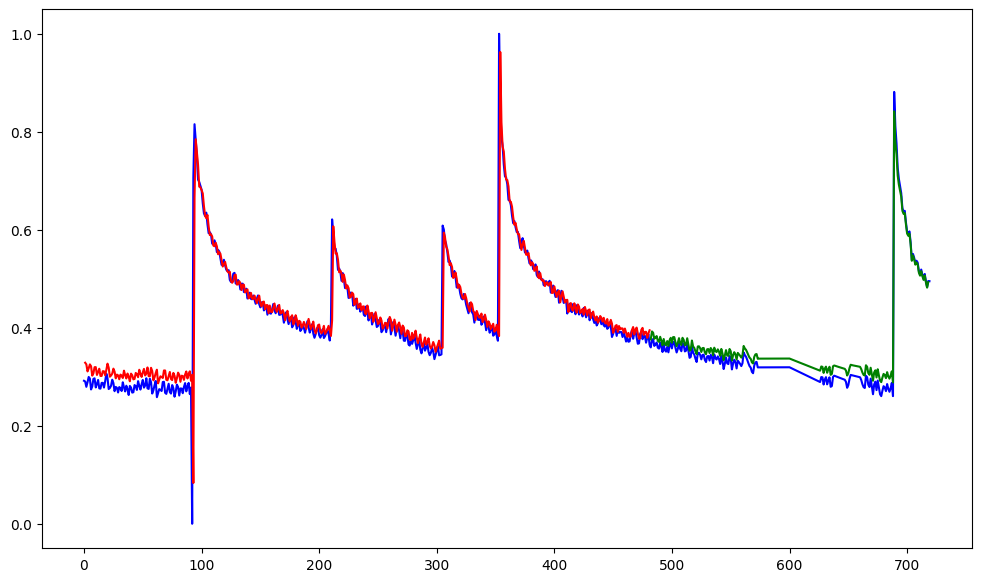

In [25]:
plot_train_n_pred(X_train, X_test, total, model)